In [3]:
import torch
import numpy as np
from transformers import AutoProcessor, XCLIPVisionModel
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor
import matplotlib.pyplot as plt
from datasets import load_dataset
from pathlib import Path
import pandas as pd
import numpy as np
from torchvision.transforms import RandomResizedCrop,  Compose, Normalize, ToTensor, Resize

In [4]:
data = load_dataset('TornikeO/imigue')

In [5]:
data['train'][:10]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180>],
 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

['arms_akimbo', 'biting_nails', 'buckle_button,_pulling_shirt_collar,_adjusting_tie', 'bulging_face,_deep_breath', 'covering_face', 'crossing_fingers', 'dustoffing_clothes', 'folding_arms', 'head_up', 'hold_back_arms', 'illustrative_body_language', 'minaret_gesture', 'moving_torso', 'playing_with_or_adjusting_hair', 'playing_with_or_manipulating_objects', 'pressing_lips', 'putting_arms_behind_body', 'rubbing_eyes', 'rubbing_or_holding_hands', 'scratching_back', 'scratching_or_touching_arms', 'shaking_shoulders', 'sitting_upright', 'touching_ears', 'touching_hat', 'touching_jaw', 'touching_or_covering_suprasternal_notch', 'touching_or_scratching_facial_parts', 'touching_or_scratching_forehead', 'touching_or_scratching_head', 'touching_or_scratching_neck', 'turtle_neck']
torch.Size([3, 224, 224])
dict_keys(['label', 'pixel_values'])


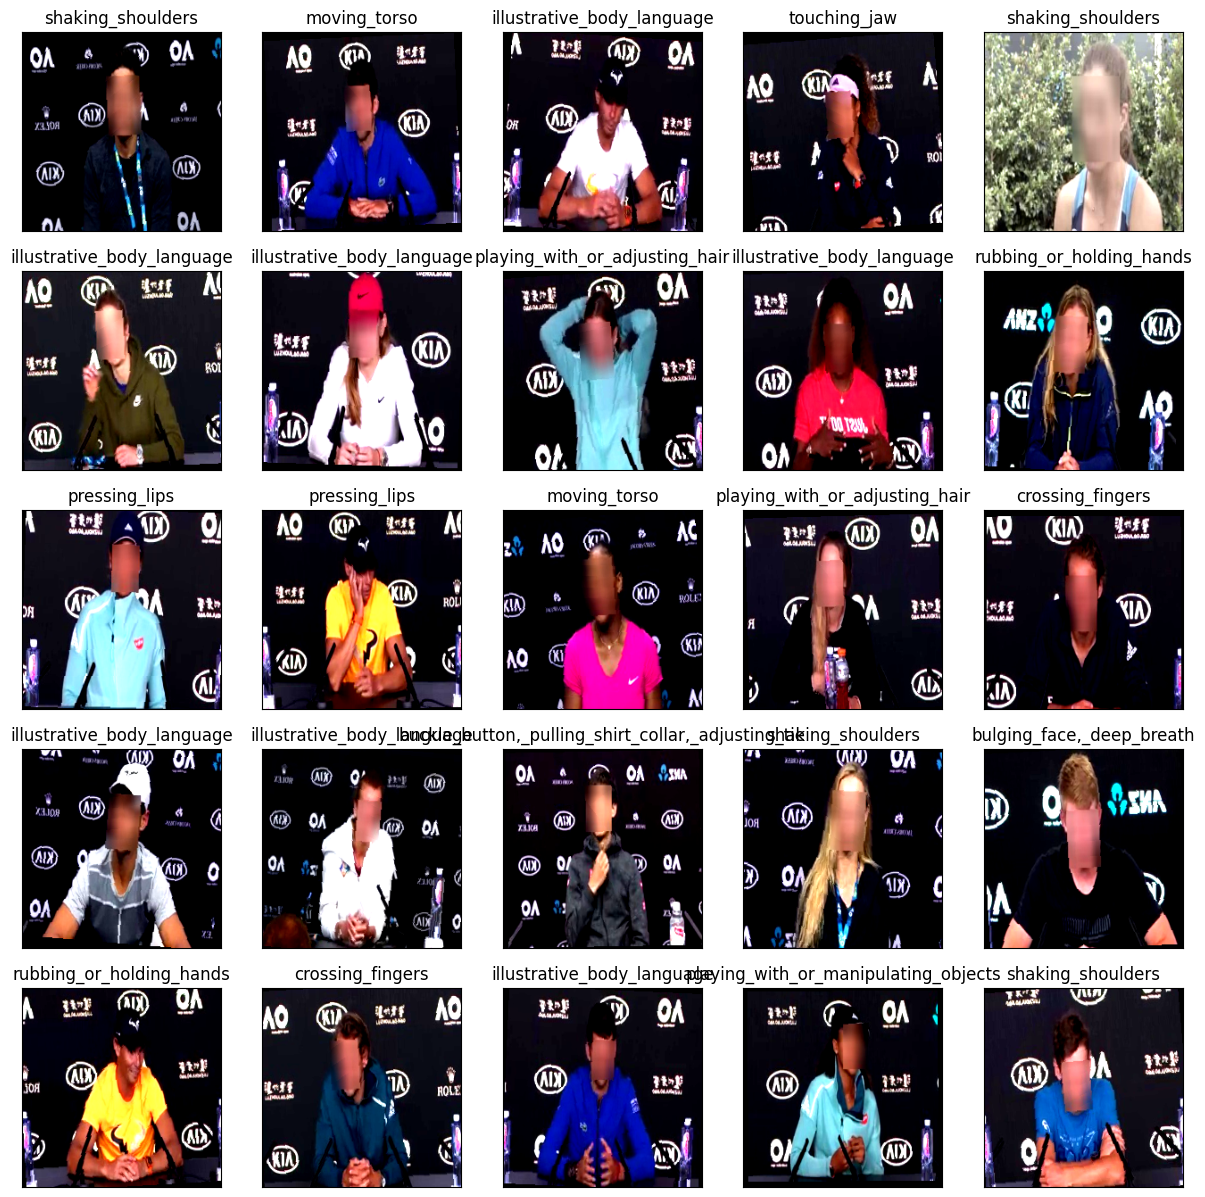

In [6]:
import torchvision.transforms as T
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

train_transforms = T.Compose([
    T.Resize(size=size),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=5,
                   translate=(0.01, 0.03),
                   scale=(.95, 1.05),),
    T.ToTensor(),
    normalize,
])

val_transforms = T.Compose([
    T.Resize(size=size),
    T.ToTensor(),
    normalize,
])

def preprocess_train(examples):
    examples["pixel_values"] = [
        train_transforms(image) for image in examples["image"]
    ]
    del examples['image']
    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [
        val_transforms(image) for image in examples["image"]
    ]
    del examples['image']
    return examples

id2label = data['train'].features['label'].names
label2id = dict(zip(id2label, range(len(id2label))))
print(id2label)

ds = data['train'].train_test_split(test_size=.2, stratify_by_column='label')

train_ds, val_ds = ds['train'], ds['test']
train_ds.set_transform(preprocess_train, columns=['image', 'label'], output_all_columns=False)
val_ds.set_transform(preprocess_val, columns=['image', 'label'], output_all_columns=False)

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.ravel()
for i, (d, ax) in enumerate(zip(train_ds, axs.ravel())):
    if i == 0:
        print(d['pixel_values'].shape)
        print(d.keys())
    ax: plt.Axes = ax
    ax.imshow((d['pixel_values'].permute(1,2,0) + .7).clip(0,1))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_title(id2label[d['label']])

In [7]:
train_ds, val_ds

(Dataset({
     features: ['image', 'label'],
     num_rows: 48411
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 12103
 }))

In [12]:
import numpy as np
import evaluate
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [9]:
model = AutoModelForImageClassification.from_pretrained(
    'model',
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [13]:
from sklearn.metrics import classification_report
accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    acc = accuracy.compute(predictions=predictions, references=labels)
    report = classification_report(labels, predictions, output_dict=True)
    per_class_acc = {f"{id2label[class_id]}": report[str(class_id)]['precision'] for class_id in range(len(label2id))}
    return {**acc, **f1, **per_class_acc}
  
training_args = TrainingArguments(
    output_dir="vit-base-patch16-224-imigue",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    # This MIGHT seem like a crazy high number, but it's fine rtx4090 can handle it with fp16
    # Also since classes are imba, large enough batch size will make small classes contribute to grads
    # making it more likely that model will learn imba classes too
    per_device_train_batch_size=128, 
    gradient_accumulation_steps=4,  
    per_device_eval_batch_size=128 * 2, 
    dataloader_num_workers=24,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    seed=42,
    fp16=True,
    # use_cpu=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [14]:
# Let's check initial acc
print(trainer.evaluate())

{'eval_loss': 0.645025372505188, 'eval_accuracy': 0.8112038337602248, 'eval_f1': 0.6905188537687805, 'eval_arms_akimbo': 1.0, 'eval_biting_nails': 0.0, 'eval_buckle_button,_pulling_shirt_collar,_adjusting_tie': 0.8923076923076924, 'eval_bulging_face,_deep_breath': 0.6161616161616161, 'eval_covering_face': 0.8787878787878788, 'eval_crossing_fingers': 0.8468033775633294, 'eval_dustoffing_clothes': 0.77, 'eval_folding_arms': 0.759825327510917, 'eval_head_up': 0.8181818181818182, 'eval_hold_back_arms': 0.7014925373134329, 'eval_illustrative_body_language': 0.8520814880425155, 'eval_minaret_gesture': 0.967741935483871, 'eval_moving_torso': 0.7914438502673797, 'eval_playing_with_or_adjusting_hair': 0.8392857142857143, 'eval_playing_with_or_manipulating_objects': 0.90527950310559, 'eval_pressing_lips': 0.7363238512035011, 'eval_putting_arms_behind_body': 0.0, 'eval_rubbing_eyes': 0.8793103448275862, 'eval_rubbing_or_holding_hands': 0.8179519595448799, 'eval_scratching_back': 0.875, 'eval_scra

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# Now run that mf
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 3.481083631515503, 'eval_accuracy': 0.022308518549120054, 'eval_f1': 0.011607841798121129, 'eval_arms_akimbo': 0.0037243947858473, 'eval_biting_nails': 0.0, 'eval_buckle_button,_pulling_shirt_collar,_adjusting_tie': 0.009900990099009901, 'eval_bulging_face,_deep_breath': 0.0, 'eval_covering_face': 0.0, 'eval_crossing_fingers': 0.0, 'eval_dustoffing_clothes': 0.0, 'eval_folding_arms': 0.0, 'eval_head_up': 0.0006369426751592356, 'eval_hold_back_arms': 0.0, 'eval_illustrative_body_language': 0.18604651162790697, 'eval_minaret_gesture': 0.0, 'eval_moving_torso': 0.08169291338582677, 'eval_playing_with_or_adjusting_hair': 0.0, 'eval_playing_with_or_manipulating_objects': 0.039473684210526314, 'eval_pressing_lips': 0.10249307479224377, 'eval_putting_arms_behind_body': 0.0, 'eval_rubbing_eyes': 0.0, 'eval_rubbing_or_holding_hands': 0.0, 'eval_scratching_back': 0.0, 'eval_scratching_or_touching_arms': 0.08771929824561403, 'eval_shaking_shoulders': 0.0, 'eval_sitting_upright': 0.0

Epoch,Training Loss,Validation Loss,Accuracy,F1,Arms Akimbo,Biting Nails,"Buckle Button, Pulling Shirt Collar, Adjusting Tie","Bulging Face, Deep Breath",Covering Face,Crossing Fingers,Dustoffing Clothes,Folding Arms,Head Up,Hold Back Arms,Illustrative Body Language,Minaret Gesture,Moving Torso,Playing With Or Adjusting Hair,Playing With Or Manipulating Objects,Pressing Lips,Putting Arms Behind Body,Rubbing Eyes,Rubbing Or Holding Hands,Scratching Back,Scratching Or Touching Arms,Shaking Shoulders,Sitting Upright,Touching Ears,Touching Hat,Touching Jaw,Touching Or Covering Suprasternal Notch,Touching Or Scratching Facial Parts,Touching Or Scratching Forehead,Touching Or Scratching Head,Touching Or Scratching Neck,Turtle Neck
0,2.736600,2.694496,0.274230,0.014243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.273307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.720000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.153300,2.070161,0.480790,0.147043,0.000000,0.000000,0.000000,0.000000,0.000000,0.553459,0.000000,0.588398,0.000000,0.000000,0.637352,0.000000,0.395659,0.000000,0.568738,0.503067,0.000000,0.000000,0.468992,0.000000,0.595588,0.317397,0.000000,0.000000,0.000000,0.303668,0.000000,0.154639,0.000000,0.000000,0.000000,0.000000
2,1.760700,1.707366,0.555482,0.220621,0.000000,0.000000,0.000000,0.000000,0.000000,0.645000,0.000000,0.534884,0.000000,0.000000,0.669442,0.000000,0.422636,0.000000,0.625966,0.472414,0.000000,0.000000,0.649051,0.000000,0.517672,0.368953,0.000000,0.000000,0.000000,0.525575,0.000000,0.351211,0.000000,0.492647,0.531429,0.000000
4,1.363000,1.382576,0.615467,0.263920,0.000000,0.000000,0.857143,0.000000,0.000000,0.726644,0.000000,0.588694,0.000000,0.400000,0.683643,0.000000,0.452479,0.000000,0.807292,0.540918,0.000000,0.000000,0.655413,0.000000,0.652681,0.434150,0.000000,0.000000,0.000000,0.732472,0.000000,0.518261,0.000000,0.382576,0.622449,0.000000
5,1.257000,1.311991,0.628687,0.305400,0.000000,0.000000,0.692308,0.000000,0.000000,0.707395,1.000000,0.552066,0.000000,0.516129,0.737187,0.000000,0.496222,0.000000,0.714286,0.509830,0.000000,0.000000,0.614125,0.000000,0.579032,0.492718,0.000000,0.000000,1.000000,0.744227,0.000000,0.452855,0.538462,0.521739,0.713376,0.000000
6,1.196200,1.221483,0.649839,0.361979,0.000000,0.000000,0.666667,0.500000,0.000000,0.687251,1.000000,0.614000,0.000000,0.493976,0.728009,0.875000,0.521945,0.000000,0.753561,0.546632,0.000000,0.555556,0.674040,0.000000,0.591415,0.503180,0.000000,0.500000,0.944444,0.774011,0.000000,0.558140,0.422222,0.571429,0.702128,0.000000
8,1.044100,1.151152,0.661654,0.432780,0.000000,0.000000,0.738095,0.666667,0.941176,0.732673,0.833333,0.631263,0.800000,0.430464,0.770612,0.826087,0.562249,0.000000,0.770893,0.455017,0.000000,0.666667,0.689455,0.000000,0.572289,0.548359,1.000000,0.666667,0.903226,0.700800,0.000000,0.586639,0.542857,0.673333,0.679245,0.000000
9,1.012900,1.089975,0.683467,0.476274,0.000000,0.000000,0.746269,0.526316,0.952381,0.696878,0.780488,0.664459,0.750000,0.425000,0.725531,0.863636,0.570938,0.777778,0.817352,0.569507,0.000000,0.739130,0.718599,1.000000,0.692946,0.575382,1.000000,0.400000,0.852941,0.824131,0.000000,0.619666,0.600000,0.691781,0.734328,0.000000
10,0.944400,1.063621,0.686524,0.490378,0.000000,0.000000,0.761905,0.617021,0.952381,0.781250,0.785714,0.693587,0.761905,0.470588,0.751522,0.869565,0.553974,0.583333,0.821981,0.603571,0.000000,0.760000,0.669967,1.000000,0.618740,0.541101,0.714286,0.545455,0.882353,0.820774,0.000000,0.600355,0.561404,0.712418,0.801370,0.000000
12,0.867000,1.019005,0.703214,0.532863,0.000000,0.000000,0.712329,0.538462,0.900000,0.716527,0.712121,0.648000,0.760000,0.526718,0.771322,0.863636,0.624501,0.541667,0.802985,0.655303,0.000000,0.760870,0.717918,1.000000,0.667269,0.549451,0.500000,0.638889,0.868421,0.809055,0.000000,0.670886,0.629630,0.720779,0.800000,0.000000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/m

TrainOutput(global_step=1880, training_loss=1.2020739580722566, metrics={'train_runtime': 2038.3965, 'train_samples_per_second': 474.991, 'train_steps_per_second': 0.922, 'total_flos': 7.446199839361185e+19, 'train_loss': 1.2020739580722566, 'epoch': 19.84})

In [ ]:
model.config.id2label = dict(zip(range(len(id2label)), id2label))

training_args = TrainingArguments(
    output_dir="model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5, # Smalle learning rate
    # This MIGHT seem like a crazy high number, but it's fine rtx4090 can handle it with fp16
    # Also since classes are imba, large enough batch size will make small classes contribute to grads
    # making it more likely that model will learn imba classes too
    per_device_train_batch_size=128, 
    gradient_accumulation_steps=4,  
    per_device_eval_batch_size=128 * 2, 
    dataloader_num_workers=24,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    seed=42,
    fp16=True,
    # use_cpu=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

# Let's check initial acc
print(trainer.evaluate())

# Now run that mf
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9323217272758484, 'eval_accuracy': 0.7248616045608527, 'eval_f1': 0.6071364464364642, 'eval_arms_akimbo': 1.0, 'eval_biting_nails': 0.0, 'eval_buckle_button,_pulling_shirt_collar,_adjusting_tie': 0.7692307692307693, 'eval_bulging_face,_deep_breath': 0.5394736842105263, 'eval_covering_face': 0.8823529411764706, 'eval_crossing_fingers': 0.797011207970112, 'eval_dustoffing_clothes': 0.7125, 'eval_folding_arms': 0.6928251121076233, 'eval_head_up': 0.7931034482758621, 'eval_hold_back_arms': 0.6190476190476191, 'eval_illustrative_body_language': 0.7757331799884991, 'eval_minaret_gesture': 0.9, 'eval_moving_torso': 0.6339285714285714, 'eval_playing_with_or_adjusting_hair': 0.7111111111111111, 'eval_playing_with_or_manipulating_objects': 0.837138508371385, 'eval_pressing_lips': 0.6350210970464135, 'eval_putting_arms_behind_body': 0.0, 'eval_rubbing_eyes': 0.8070175438596491, 'eval_rubbing_or_holding_hands': 0.7428214731585518, 'eval_scratching_back': 0.8461538461538461, 'eval_s

Epoch,Training Loss,Validation Loss,Accuracy,F1,Arms Akimbo,Biting Nails,"Buckle Button, Pulling Shirt Collar, Adjusting Tie","Bulging Face, Deep Breath",Covering Face,Crossing Fingers,Dustoffing Clothes,Folding Arms,Head Up,Hold Back Arms,Illustrative Body Language,Minaret Gesture,Moving Torso,Playing With Or Adjusting Hair,Playing With Or Manipulating Objects,Pressing Lips,Putting Arms Behind Body,Rubbing Eyes,Rubbing Or Holding Hands,Scratching Back,Scratching Or Touching Arms,Shaking Shoulders,Sitting Upright,Touching Ears,Touching Hat,Touching Jaw,Touching Or Covering Suprasternal Notch,Touching Or Scratching Facial Parts,Touching Or Scratching Forehead,Touching Or Scratching Head,Touching Or Scratching Neck,Turtle Neck
0,0.639500,0.939914,0.721887,0.603383,1.000000,0.000000,0.723684,0.537037,0.878788,0.805951,0.727273,0.681128,0.793103,0.574468,0.774008,0.900000,0.597793,0.733333,0.823088,0.621704,0.000000,0.769231,0.749679,0.785714,0.697719,0.628910,0.445946,0.681818,0.868421,0.822222,1.000000,0.690789,0.714286,0.788732,0.835052,0.000000
1,0.591900,0.933630,0.721970,0.602397,1.000000,0.000000,0.757576,0.551282,0.878788,0.801020,0.750000,0.686047,0.785714,0.633333,0.785377,0.900000,0.612245,0.727273,0.835115,0.637913,0.000000,0.823529,0.739076,0.785714,0.699809,0.586133,0.472973,0.652174,0.864865,0.797348,1.000000,0.689130,0.705882,0.751678,0.842105,0.000000
2,0.617400,0.935386,0.722383,0.607995,1.000000,0.000000,0.735294,0.510638,0.861111,0.824632,0.703704,0.725441,0.806452,0.601504,0.774571,0.900000,0.628472,0.693878,0.830793,0.602830,0.000000,0.826923,0.749682,0.785714,0.702259,0.610470,0.425287,0.690476,0.916667,0.792381,1.000000,0.693333,0.725490,0.829630,0.822526,0.000000
4,0.573100,0.927038,0.726266,0.614290,1.000000,0.000000,0.769231,0.540230,0.857143,0.804847,0.725000,0.694382,0.806452,0.624000,0.779710,0.900000,0.633630,0.730769,0.833841,0.632124,0.000000,0.813559,0.741250,0.733333,0.707510,0.605061,0.458824,0.688889,0.891892,0.802303,1.000000,0.706278,0.745098,0.805755,0.813333,0.000000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/m

TrainOutput(global_step=470, training_loss=0.5957278251647949, metrics={'train_runtime': 513.06, 'train_samples_per_second': 471.787, 'train_steps_per_second': 0.916, 'total_flos': 1.8621371194949763e+19, 'train_loss': 0.5957278251647949, 'epoch': 4.96})

In [10]:
# model.config.id2label = dict(zip(range(len(id2label)), id2label))

training_args = TrainingArguments(
    output_dir="model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5, # Smalle learning rate
    # This MIGHT seem like a crazy high number, but it's fine rtx4090 can handle it with fp16
    # Also since classes are imba, large enough batch size will make small classes contribute to grads
    # making it more likely that model will learn imba classes too
    per_device_train_batch_size=128, 
    gradient_accumulation_steps=4,  
    per_device_eval_batch_size=128 * 2, 
    dataloader_num_workers=24,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    seed=42,
    fp16=True,
    # use_cpu=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

print(trainer.evaluate())

NameError: name 'data_collator' is not defined

In [15]:
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/TornikeO/vit-base-patch16-224-imigue/commit/383ca831ed59b3e9d973a8f19383f544a1770477', commit_message='End of training', commit_description='', oid='383ca831ed59b3e9d973a8f19383f544a1770477', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [19]:
from transformers import pipeline

classifier = pipeline("image-classification", model='TornikeO/vit-base-patch16-224-imigue')

config.json:   0%|          | 0.00/2.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

In [ ]:
# data = load_dataset('TornikeO/imigue',)

Actual class  arms_akimbo predicted hold_back_arms  31.140 % 


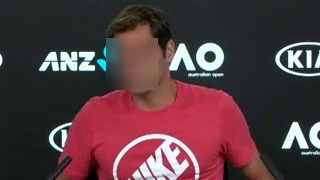

Actual class  bulging_face,_deep_breath predicted hold_back_arms  53.010 % 


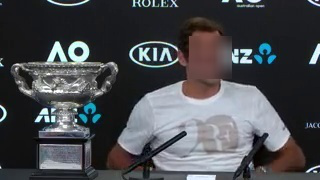

Actual class  bulging_face,_deep_breath predicted bulging_face,_deep_breath  24.427 % 


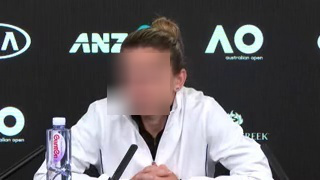

Actual class  bulging_face,_deep_breath predicted touching_jaw  70.937 % 


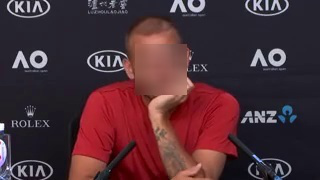

Actual class  bulging_face,_deep_breath predicted bulging_face,_deep_breath  43.703 % 


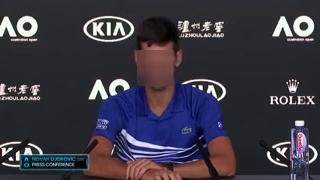

Actual class  crossing_fingers predicted crossing_fingers  95.398 % 


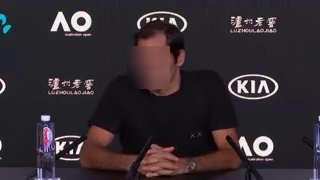

Actual class  crossing_fingers predicted crossing_fingers  80.530 % 


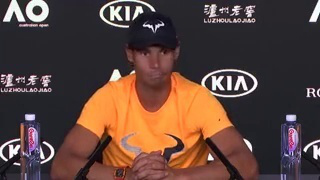

Actual class  crossing_fingers predicted crossing_fingers  91.633 % 


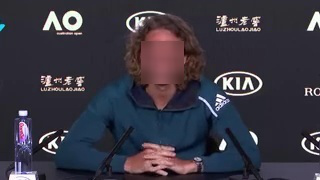

Actual class  crossing_fingers predicted crossing_fingers  85.556 % 


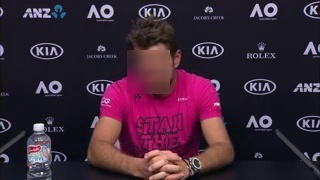

Actual class  crossing_fingers predicted crossing_fingers  92.299 % 


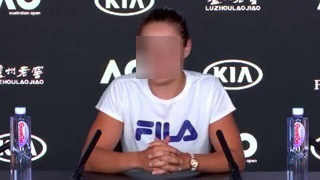

Actual class  crossing_fingers predicted crossing_fingers  96.227 % 


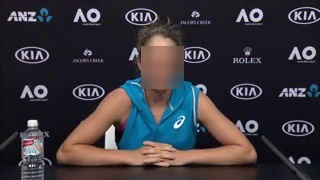

Actual class  crossing_fingers predicted crossing_fingers  96.112 % 


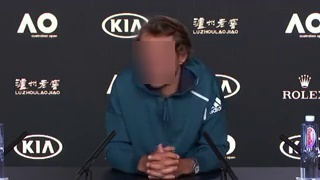

Actual class  crossing_fingers predicted crossing_fingers  87.597 % 


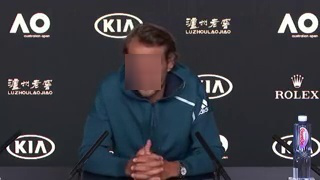

Actual class  dustoffing_clothes predicted illustrative_body_language  26.085 % 


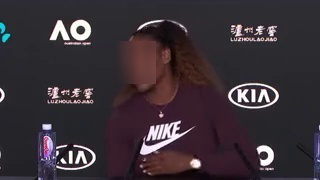

Actual class  folding_arms predicted folding_arms  91.596 % 


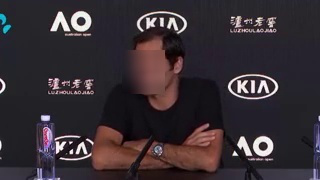

Actual class  folding_arms predicted folding_arms  93.783 % 


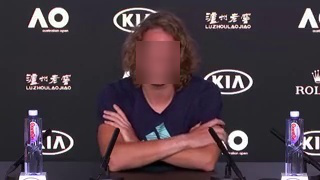

Actual class  folding_arms predicted folding_arms  85.155 % 


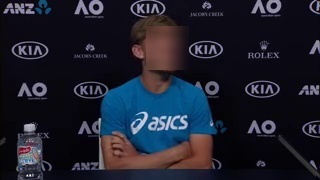

Actual class  folding_arms predicted folding_arms  94.805 % 


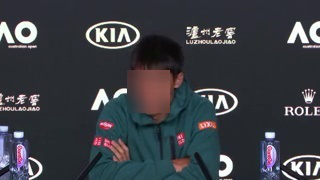

Actual class  hold_back_arms predicted hold_back_arms  68.707 % 


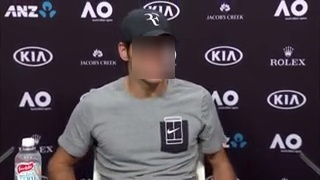

Actual class  hold_back_arms predicted hold_back_arms  62.546 % 


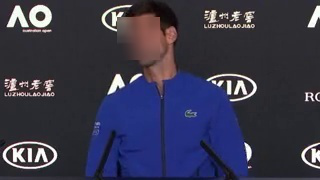

In [26]:
from IPython.display import display
for i in range(0, 10_000, 500):
    sample = data['train'][i]
    # print(sample)
    sample_img = sample['image']
    sample_class = sample['label'] # Don't forget this!
    pred = classifier(sample_img)
    print('Actual class ',  id2label[sample_class], 'predicted', pred[0]['label'], f' {pred[0]["score"] * 100:.3f} % ')
    display(sample_img)